## Mini-Project 1: Network Intrusion Detection

## Importing libraries and creating required functions


In [16]:
from sklearn import metrics

In [17]:
%matplotlib inline
import collections
from sklearn import preprocessing
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix


import matplotlib.pyplot as plt
import shutil

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
   

#Plot an ROC. pred - the predictions, y - the expected output.

def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) * (normalized_high - normalized_low) + normalized_low


In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc,classification_report

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

## Reading training-set.csv file

In [19]:
import pandas as pd
import os 
#path = ".D:/CSC 215/Project Project"
#file_read = os.path.join(path,"UNSW_NB15_training-set_csc215.csv")
data= pd.read_csv('UNSW_NB15_training-set_csc215.csv')
data = pd.read_csv("UNSW_NB15_training-set_csc215.csv",na_values=['NA','?'])

data.head()
#cwd = os.getcwd()
#print(cwd)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


## Data Balancing

In [20]:
#Data_Balncing
ind=data[data['service']=='-'].index
data.drop(ind, inplace=True)
data_normal_count=len(data[data['label'] == 1])
data_attack_count=len(data[data['label'] == 0])
print("Before balancing attack data",data_normal_count)
print("Before balancing normal data",data_attack_count)
data_normal=(data[data['label'] == 1])
data_attack=(data[data['label'] == 0])

if (data_normal_count>data_attack_count):
    frames=[data_normal.head(data_attack_count),data_attack.head(data_attack_count) ]
    data= pd.concat(frames)   #dfNormalSet.head(dfAttackCount)+dfAttackSet.head(dfAttackCount)
else:
    frames=[data_normal.head(data_normal_count),data_attack.head(data_normal_count) ]
    data= pd.concat(frames)

data_normal_count=len(data[data['label'] == 1])
data_attack_count=len(data[data['label'] == 0])

print("After balancing attack data",data_normal_count)
print("After balancing normal data",data_attack_count)

Before balancing attack data 61685
Before balancing normal data 19488
After balancing attack data 19488
After balancing normal data 19488


In [21]:
#encode_numeric_zscore(data, 'sloss', mean=None, sd=None)
#encode_numeric_zscore(data, 'dloss', mean=None, sd=None)
#encode_numeric_zscore(data, 'dur', mean=None, sd=None)
#encode_numeric_zscore(data, 'rate', mean=None, sd=None)
#encode_numeric_zscore(data, 'spkts', mean=None, sd=None)
#encode_numeric_zscore(data, 'dpkts', mean=None, sd=None)
#Lable_data=data['label']
#data.drop('label',axis=1,inplace=True)


In [22]:
#data.drop('sttl', axis=1,inplace=True)
#data.drop('dttl', axis=1,inplace=True)
#data.drop(['sjit','djit','sinpkt','dinpkt','tcprtt','synack','ackdat','ct_srv_src','ct_srv_dst','ct_dst_ltm'], axis = 1, inplace=True)
#data.drop('ct_src_ltm',1,inplace=True)
#data.drop(['ct_src_dport_ltm', 'ct_dst_sport_ltm'],1,inplace=True)

In [23]:
len(data.columns)
data.columns
#data.drop(['ct_src_dport_ltm', 'ct_dst_sport_ltm'],1,inplace=True)

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')

## Data Pre-processing of training data

In [24]:
#encode_numeric_zscore(data, 'sloss', mean=None, sd=None)
#encode_numeric_zscore(data, 'dloss', mean=None, sd=None)
#encode_numeric_zscore(data, 'dur', mean=None, sd=None)
encode_numeric_zscore(data, 'rate', mean=None, sd=None)
#encode_numeric_zscore(data, 'ackdat', mean=None, sd=None)
#encode_numeric_zscore(data, 'ct_dst_src_ltm', mean=None, sd=None)
encode_numeric_zscore(data, 'spkts', mean=None, sd=None)
encode_numeric_zscore(data, 'dpkts', mean=None, sd=None)
encode_numeric_zscore(data, 'stcpb', mean=None, sd=None)
encode_numeric_zscore(data, 'dtcpb', mean=None, sd=None)
encode_numeric_zscore(data, 'sload', mean=None, sd=None)
encode_numeric_zscore(data, 'dload', mean=None, sd=None)
encode_numeric_zscore(data, 'synack', mean=None, sd=None)

encode_numeric_zscore(data, 'sinpkt', mean=None, sd=None)
encode_numeric_zscore(data, 'dinpkt', mean=None, sd=None)

encode_numeric_zscore(data, 'ct_src_ltm', mean=None, sd=None)
encode_numeric_zscore(data, 'ct_dst_ltm', mean=None, sd=None)

#encode_numeric_zscore(data, 'ct_dst_sport_ltm', mean=None, sd=None)

#encode_text_dummy(data, 'ct_state_ttl')
#encode_numeric_zscore(data, 'ct_dst_src_ltm', mean=None, sd=None)
#encode_numeric_zscore(data, 'sjit', mean=None, sd=None)
#encode_numeric_zscore(data, 'sjit', mean=None, sd=None)
#encode_numeric_zscore(data, 'tcprtt', mean=None, sd=None)

remove_outliers(data,"ct_srv_src",data["ct_srv_src"].std())
                      
#remove_outliers(data,"rate",data["rate"].std())
#encode_numeric_zscore(data, 'ct_srv_src', mean=None, sd=None)

#remove_outliers(data,"smean",data["smean"].std())
#remove_outliers(data,"dmean",data["dmean"].std())

#encode_numeric_zscore(data, 'sbytes', mean=None, sd=Noct_srv_srcne)
#encode_numeric_zscore(data, 'dbytes', mean=None, sd=None)


data.drop('id', axis=1,inplace=True)
data.drop('sjit', axis=1,inplace=True)
data.drop('djit', axis=1,inplace=True)

#data.drop('trans_depth', axis=1,inplace=True)
#data.drop(['synack','ackdat'], axis=1,inplace=True)

#data.drop('attack_cat', axis=1,inplace=True)

#data.drop('ct_ftp_cmd', axis=1,inplace=True)
#data.drop('swin', axis=1,inplace=True)
#data.drop('dwin', axis=1,inplace=True)
#data.drop('is_sm_ips_ports', axis=1,inplace=True)

encode_text_index(data,'proto')
encode_text_index(data,'state')
encode_text_index(data,'attack_cat')
encode_text_index(data,'service')
data.shape

(38817, 42)

In [25]:
#encode_text_index(data,'attack_cat')
#encode_text_index(data,'proto')
#encode_text_index(data,'state')
#encode_text_index(data,'service')
x,y = to_xy(data,'label')
y=data['label']
y.shape

(38817,)

## Reading Test-set File

In [26]:
import pandas as pd
import os 
#path = ".D:/CSC 215/Project Project"
#file_read = os.path.join(path,"UNSW_NB15_training-set_csc215.csv")
data_test= pd.read_csv('UNSW_NB15_test-set_csc215.csv')
data_test.head()
#cwd = os.getcwd()
#print(cwd)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


## Pre-processing of Testing Data

In [27]:


#encode_numeric_zscore(data_test, 'sloss', mean=None, sd=None)
#encode_numeric_zscore(data_test, 'dloss', mean=None, sd=None)
#encode_numeric_zscore(data_test, 'dur', mean=None, sd=None)
encode_numeric_zscore(data_test, 'rate', mean=None, sd=None)
#encode_numeric_zscore(data_test, 'ackdat', mean=None, sd=None)
#encode_numeric_zscore(data_test, 'ct_dst_src_ltm', mean=None, sd=None)
encode_numeric_zscore(data_test, 'sinpkt', mean=None, sd=None)
encode_numeric_zscore(data_test, 'dinpkt', mean=None, sd=None)
encode_numeric_zscore(data_test, 'ct_src_ltm', mean=None, sd=None)
encode_numeric_zscore(data_test, 'ct_dst_ltm', mean=None, sd=None)
encode_numeric_zscore(data_test, 'synack', mean=None, sd=None)
#encode_numeric_zscore(data_test, 'ct_dst_sport_ltm', mean=None, sd=None)

encode_numeric_zscore(data_test, 'spkts', mean=None, sd=None)
encode_numeric_zscore(data_test, 'dpkts', mean=None, sd=None)
encode_numeric_zscore(data_test, 'stcpb', mean=None, sd=None)
encode_numeric_zscore(data_test, 'dtcpb', mean=None, sd=None)
encode_numeric_zscore(data_test, 'sload', mean=None, sd=None)
encode_numeric_zscore(data_test, 'dload', mean=None, sd=None)
#data_test.drop('trans_depth', axis=1,inplace=True)

#encode_numeric_zscore(data_test, 'tcprtt', mean=None, sd=None)

remove_outliers(data_test,"ct_srv_src",data_test["ct_srv_src"].std())
#remove_outliers(data_test,"rate",data_test["rate"].std())

#remove_outliers(data_test,"smean",data_test["smean"].std())
#remove_outliers(data_test,"dmean",data_test["dmean"].std())
#encode_numeric_zscore(data_test, 'ct_srv_src', mean=None, sd=None)

#encode_numeric_zscore(data_test, 'sbytes', mean=None, sd=None)
#encode_numeric_zscore(data_test, 'dbytes', mean=None, sd=None)

ind=data_test[data_test['service']=='-'].index
data_test.drop(ind, inplace=True)

#encode_text_dummy(data_test, 'ct_state_ttl')

encode_text_index(data_test,'proto')
encode_text_index(data_test,'state')
encode_text_index(data_test,'service')
encode_text_index(data_test,'attack_cat')

data_test.drop('id', axis=1,inplace=True)
data_test.drop('sjit', axis=1,inplace=True)
data_test.drop('djit', axis=1,inplace=True)

#data_test.drop(['synack','ackdat'], axis=1,inplace=True)
#data_test.drop('attack_cat', axis=1,inplace=True)

#data_test.drop('ct_ftp_cmd', axis=1,inplace=True)

#data_test.drop('swin', axis=1,inplace=True)
#data_test.drop('dwin', axis=1,inplace=True)

#data_test.drop('is_sm_ips_ports', axis=1,inplace=True)

#data_test.drop('sttl', axis=1,inplace=True)
#data_test.drop('dttl', axis=1,inplace=True)
#data_test.drop(['sjit','djit','sinpkt','dinpkt','tcprtt','synack','ackdat','ct_srv_src','ct_srv_dst','ct_dst_ltm'], axis = 1, inplace=True)

#data_test.drop('ct_src_ltm',1,inplace=True)
#data_test.drop(['ct_src_dport_ltm', 'ct_dst_sport_ltm'],1,inplace=True)




## Neural Networks (Optimizer = adam and Activation Function = relu)

Train on 38817 samples, validate on 35179 samples
Epoch 1/100
38817/38817 - 9s - loss: 119.8199 - val_loss: 13.5044
Epoch 2/100
38817/38817 - 2s - loss: 69.3793 - val_loss: 12.9328
Epoch 3/100
38817/38817 - 1s - loss: 49.2193 - val_loss: 11.3022
Epoch 4/100
38817/38817 - 1s - loss: 11.6324 - val_loss: 8.5332
Epoch 5/100
38817/38817 - 1s - loss: 40.6095 - val_loss: 140.8539
Epoch 6/100
38817/38817 - 1s - loss: 38.0729 - val_loss: 7.9795
Epoch 7/100
38817/38817 - 1s - loss: 23.8603 - val_loss: 8.4639
Epoch 8/100
38817/38817 - 1s - loss: 37.1699 - val_loss: 2.4272
Epoch 9/100
38817/38817 - 1s - loss: 5.0741 - val_loss: 3.0020
Epoch 10/100
38817/38817 - 1s - loss: 10.4157 - val_loss: 5.3593
Epoch 11/100
38817/38817 - 1s - loss: 6.7098 - val_loss: 0.8475
Epoch 12/100
38817/38817 - 1s - loss: 5.5173 - val_loss: 8.1102
Epoch 13/100
38817/38817 - 1s - loss: 4.9059 - val_loss: 1.7911
Epoch 14/100
38817/38817 - 4s - loss: 3.1525 - val_loss: 18.0663
Epoch 15/100
38817/38817 - 5s - loss: 7.1676 - 

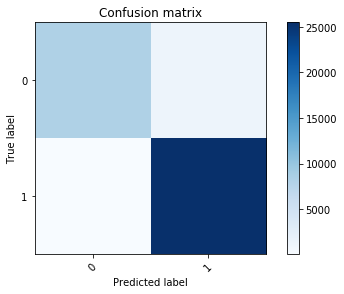

Plotting ROC Curve


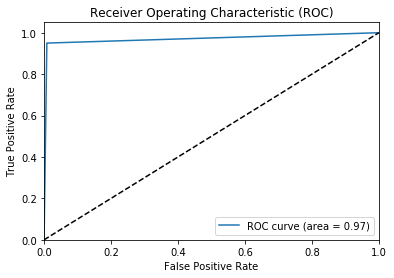

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

x,y = to_xy(data,'label')
x_test,y_test = to_xy(data_test,"label")


for i in range(4):
    model = Sequential()
    model.add(Dense(50, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(25, activation= 'relu'))
    model.add(Dense(15, activation= 'relu'))
    model.add(Dense(y.shape[1],activation='softmax'))
    adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(filepath="/dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model
    model.fit(x,y,validation_data=(x_test,y_test), batch_size= 128, callbacks=[monitor,checkpointer],verbose=2,epochs=100)
    model.load_weights('dnn/best_weights.hdf5') # load weights from best model

pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)

print("Accuracy score: {}".format(score))

score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))

score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))

score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))

print(classification_report(y_true,pred))

cm = confusion_matrix(y_true, pred)
print(cm)

print('Ploting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, "01")
plt.show()

print('Plotting ROC Curve')
plot_roc(y_true, pred)

## SGD and TANH

Train on 38817 samples, validate on 35179 samples
Epoch 1/100
38817/38817 - 6s - loss: 0.5278 - val_loss: 0.3173
Epoch 2/100
38817/38817 - 2s - loss: 0.4879 - val_loss: 0.2674
Epoch 3/100
38817/38817 - 2s - loss: 0.4758 - val_loss: 0.2731
Epoch 4/100
38817/38817 - 1s - loss: 0.4964 - val_loss: 0.2663
Epoch 5/100
38817/38817 - 1s - loss: 0.5052 - val_loss: 0.2782
Epoch 6/100
38817/38817 - 1s - loss: 0.4873 - val_loss: 0.2693
Epoch 7/100
38817/38817 - 1s - loss: 0.4884 - val_loss: 0.2711
Epoch 8/100
38817/38817 - 1s - loss: 0.4945 - val_loss: 0.2505
Epoch 9/100
38817/38817 - 1s - loss: 0.4729 - val_loss: 0.2469
Epoch 10/100
38817/38817 - 1s - loss: 0.4983 - val_loss: 0.2607
Epoch 11/100
38817/38817 - 1s - loss: 0.4942 - val_loss: 0.2768
Epoch 12/100
38817/38817 - 1s - loss: 0.4954 - val_loss: 0.2651
Epoch 13/100
38817/38817 - 1s - loss: 0.5041 - val_loss: 0.2772
Epoch 14/100
38817/38817 - 4s - loss: 0.4984 - val_loss: 0.2582
Epoch 00014: early stopping
Train on 38817 samples, validate on

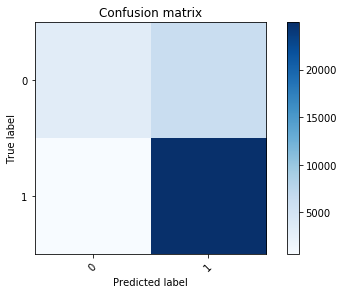

Plotting ROC Curve


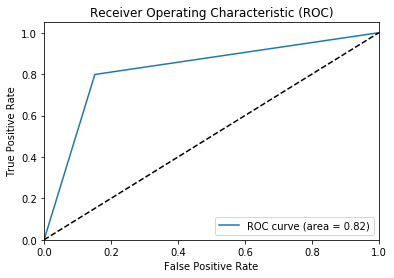

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

x,y = to_xy(data,'label')
x_test,y_test = to_xy(data_test,"label")


for i in range(4):
    model = Sequential()
    model.add(Dense(50, input_dim=x.shape[1], activation='tanh'))
    model.add(Dense(25, activation= 'tanh'))
    model.add(Dense(15, activation= 'tanh'))
    model.add(Dense(y.shape[1],activation='softmax'))
    adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(filepath="/dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model
    model.fit(x,y,validation_data=(x_test,y_test), batch_size= 128, callbacks=[monitor,checkpointer],verbose=2,epochs=100)
    #model.load_weights('dnn/best_weights.hdf5') # load weights from best model

pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)

print("Accuracy score: {}".format(score))

score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))

score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))

score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))

print(classification_report(y_true,pred))

cm = confusion_matrix(y_true, pred)
print(cm)

print('Ploting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, "01")
plt.show()

print('Plotting ROC Curve')
plot_roc(y_true, pred)

## K-nearest Neighbours

0.9635009522726626
0.964471482896522
0.9635009522726626
0.9627996574825137
              precision    recall  f1-score   support

           0       0.99      0.88      0.93      9625
           1       0.96      1.00      0.98     25554

    accuracy                           0.96     35179
   macro avg       0.97      0.94      0.95     35179
weighted avg       0.96      0.96      0.96     35179

[[ 8447  1178]
 [  106 25448]]
Ploting confusion matrix


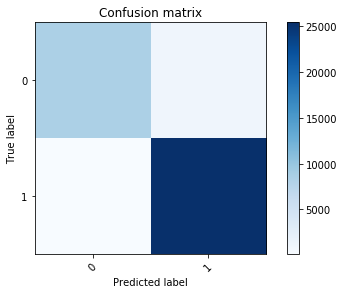

Plotting ROC Curve


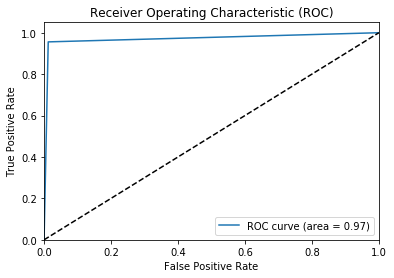

0.9708917251769522
0.9709984056846116
0.9708917251769522
0.9706008004083994
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      9625
           1       0.97      0.99      0.98     25554

    accuracy                           0.97     35179
   macro avg       0.97      0.95      0.96     35179
weighted avg       0.97      0.97      0.97     35179

[[ 8821   804]
 [  220 25334]]
Ploting confusion matrix


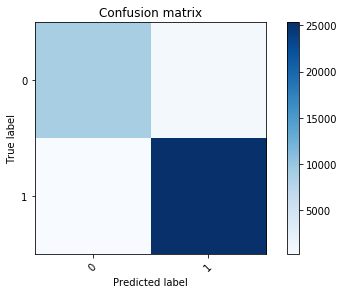

Plotting ROC Curve


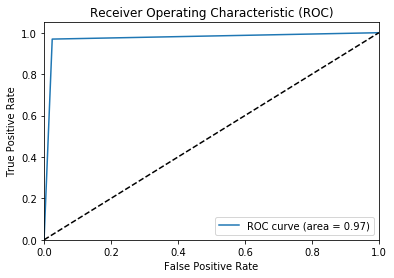

0.9606299212598425
0.9617796045412216
0.9606299212598425
0.959800567209728
              precision    recall  f1-score   support

           0       0.99      0.87      0.92      9625
           1       0.95      1.00      0.97     25554

    accuracy                           0.96     35179
   macro avg       0.97      0.93      0.95     35179
weighted avg       0.96      0.96      0.96     35179

[[ 8350  1275]
 [  110 25444]]
Ploting confusion matrix


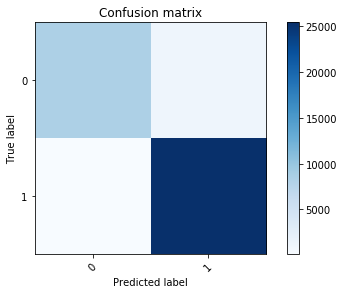

Plotting ROC Curve


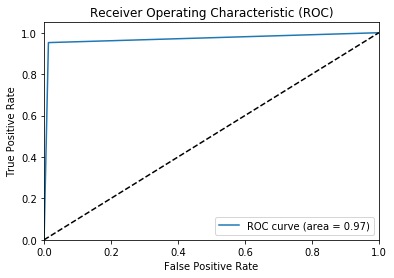

0.9690156059012479
0.9693851574145022
0.9690156059012479
0.968602356242704
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      9625
           1       0.96      0.99      0.98     25554

    accuracy                           0.97     35179
   macro avg       0.97      0.95      0.96     35179
weighted avg       0.97      0.97      0.97     35179

[[ 8697   928]
 [  162 25392]]
Ploting confusion matrix


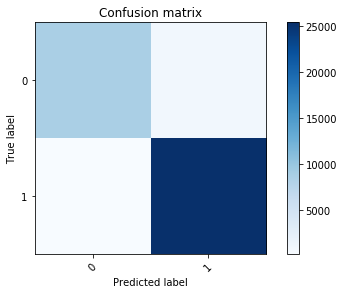

Plotting ROC Curve


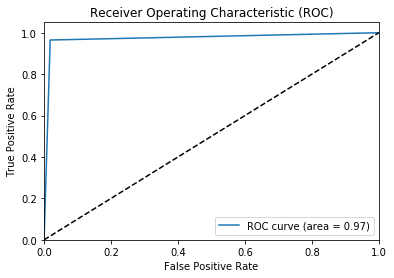

0.9594360271753034
0.9605775162839366
0.9594360271753034
0.9585701074770341
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      9625
           1       0.95      1.00      0.97     25554

    accuracy                           0.96     35179
   macro avg       0.97      0.93      0.95     35179
weighted avg       0.96      0.96      0.96     35179

[[ 8322  1303]
 [  124 25430]]
Ploting confusion matrix


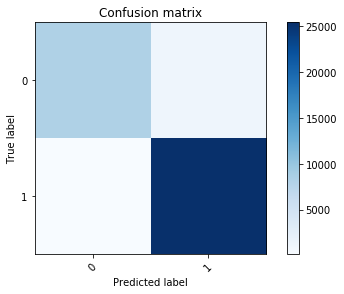

Plotting ROC Curve


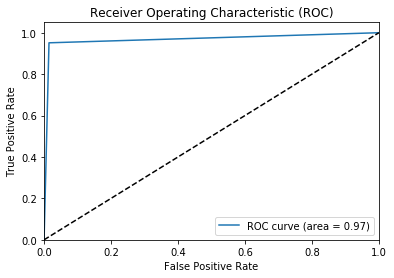

0.9672816168737031
0.9677435838535926
0.9672816168737031
0.9668040507894174
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      9625
           1       0.96      0.99      0.98     25554

    accuracy                           0.97     35179
   macro avg       0.97      0.95      0.96     35179
weighted avg       0.97      0.97      0.97     35179

[[ 8633   992]
 [  159 25395]]
Ploting confusion matrix


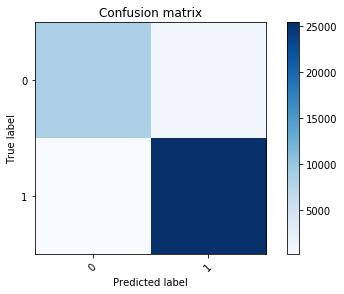

Plotting ROC Curve


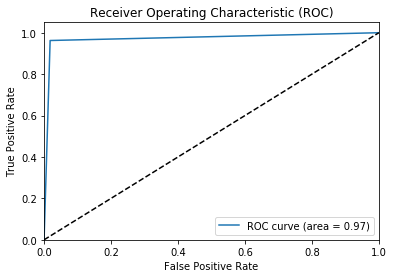

0.96074362545837
0.9617185946331677
0.96074362545837
0.9599590188776681
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      9625
           1       0.95      0.99      0.97     25554

    accuracy                           0.96     35179
   macro avg       0.97      0.93      0.95     35179
weighted avg       0.96      0.96      0.96     35179

[[ 8379  1246]
 [  135 25419]]
Ploting confusion matrix


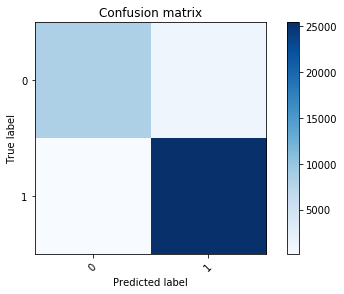

Plotting ROC Curve


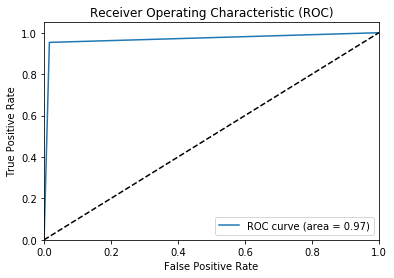

0.965831888342477
0.9662502667925889
0.965831888342477
0.9653325156393584
              precision    recall  f1-score   support

           0       0.98      0.89      0.93      9625
           1       0.96      0.99      0.98     25554

    accuracy                           0.97     35179
   macro avg       0.97      0.94      0.96     35179
weighted avg       0.97      0.97      0.97     35179

[[ 8607  1018]
 [  184 25370]]
Ploting confusion matrix


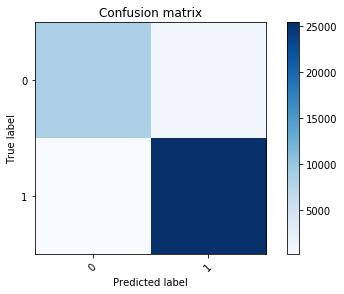

Plotting ROC Curve


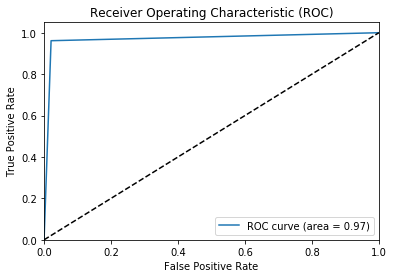

0.9600614002672049
0.9609558182881395
0.9600614002672049
0.9592758448117357
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      9625
           1       0.95      0.99      0.97     25554

    accuracy                           0.96     35179
   macro avg       0.97      0.93      0.95     35179
weighted avg       0.96      0.96      0.96     35179

[[ 8375  1250]
 [  155 25399]]
Ploting confusion matrix


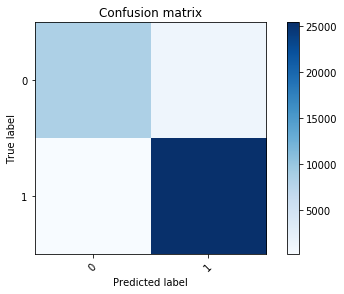

Plotting ROC Curve


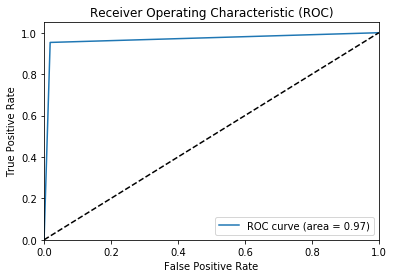

0.9646948463572017
0.9652097623749859
0.9646948463572017
0.9641399318716206
              precision    recall  f1-score   support

           0       0.98      0.89      0.93      9625
           1       0.96      0.99      0.98     25554

    accuracy                           0.96     35179
   macro avg       0.97      0.94      0.95     35179
weighted avg       0.97      0.96      0.96     35179

[[ 8558  1067]
 [  175 25379]]
Ploting confusion matrix


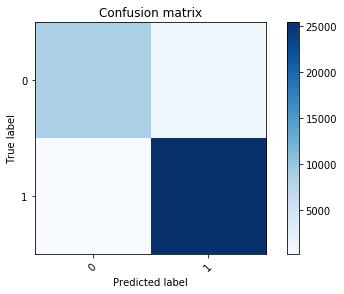

Plotting ROC Curve


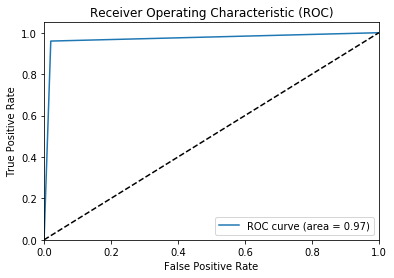

0.9598908439694136
0.9608534365848213
0.9598908439694136
0.959082808901624
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      9625
           1       0.95      0.99      0.97     25554

    accuracy                           0.96     35179
   macro avg       0.97      0.93      0.95     35179
weighted avg       0.96      0.96      0.96     35179

[[ 8360  1265]
 [  146 25408]]
Ploting confusion matrix


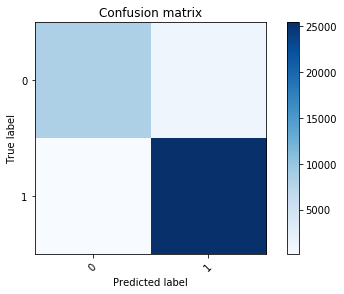

Plotting ROC Curve


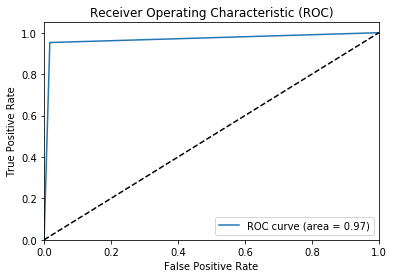

0.9636715085704539
0.9642597658853389
0.9636715085704539
0.9630698422799256
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      9625
           1       0.96      0.99      0.98     25554

    accuracy                           0.96     35179
   macro avg       0.97      0.94      0.95     35179
weighted avg       0.96      0.96      0.96     35179

[[ 8518  1107]
 [  171 25383]]
Ploting confusion matrix


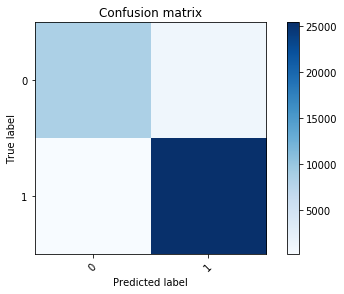

Plotting ROC Curve


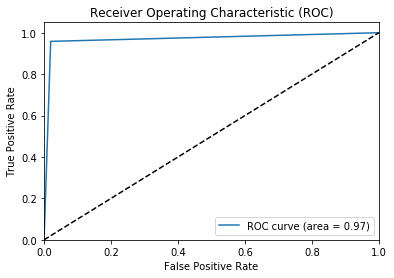

0.9590380624804571
0.9600136604976341
0.9590380624804571
0.9581997793076086
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      9625
           1       0.95      0.99      0.97     25554

    accuracy                           0.96     35179
   macro avg       0.97      0.93      0.95     35179
weighted avg       0.96      0.96      0.96     35179

[[ 8337  1288]
 [  153 25401]]
Ploting confusion matrix


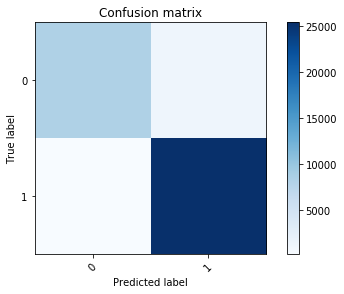

Plotting ROC Curve


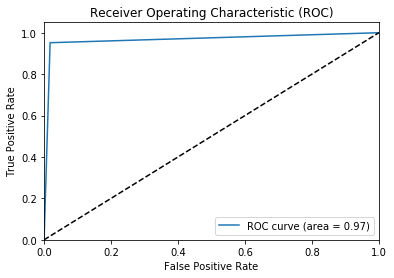

0.961738537195486
0.9623913227435034
0.961738537195486
0.9610663516853291
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      9625
           1       0.96      0.99      0.97     25554

    accuracy                           0.96     35179
   macro avg       0.97      0.94      0.95     35179
weighted avg       0.96      0.96      0.96     35179

[[ 8458  1167]
 [  179 25375]]
Ploting confusion matrix


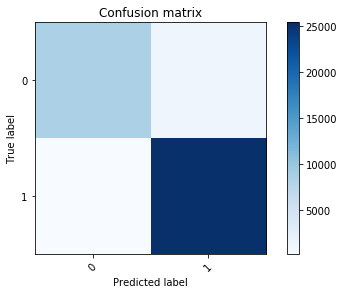

Plotting ROC Curve


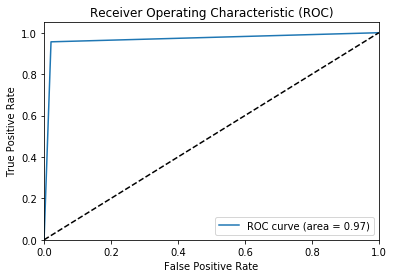

0.95787259444555
0.9589496047944913
0.95787259444555
0.9569707557667632
              precision    recall  f1-score   support

           0       0.98      0.86      0.92      9625
           1       0.95      0.99      0.97     25554

    accuracy                           0.96     35179
   macro avg       0.97      0.93      0.94     35179
weighted avg       0.96      0.96      0.96     35179

[[ 8293  1332]
 [  150 25404]]
Ploting confusion matrix


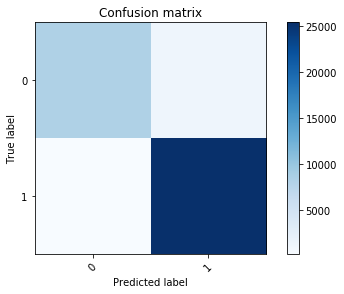

Plotting ROC Curve


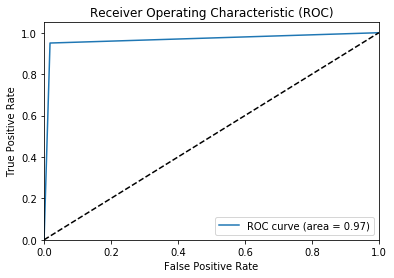

0.9617953892947497
0.9624182367718627
0.9617953892947497
0.9611331074944651
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      9625
           1       0.96      0.99      0.97     25554

    accuracy                           0.96     35179
   macro avg       0.97      0.94      0.95     35179
weighted avg       0.96      0.96      0.96     35179

[[ 8465  1160]
 [  184 25370]]
Ploting confusion matrix


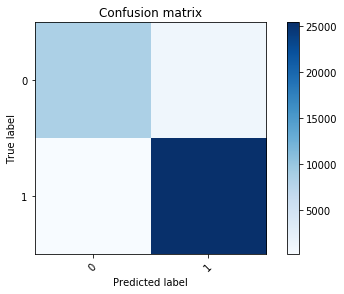

Plotting ROC Curve


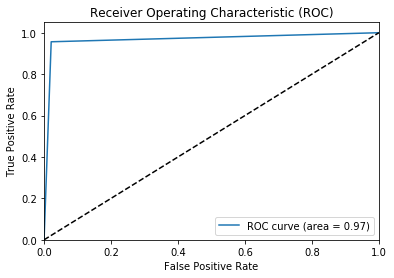

0.9564512919639557
0.9575208341905128
0.9564512919639557
0.9555032158404333
              precision    recall  f1-score   support

           0       0.98      0.86      0.92      9625
           1       0.95      0.99      0.97     25554

    accuracy                           0.96     35179
   macro avg       0.96      0.93      0.94     35179
weighted avg       0.96      0.96      0.96     35179

[[ 8259  1366]
 [  166 25388]]
Ploting confusion matrix


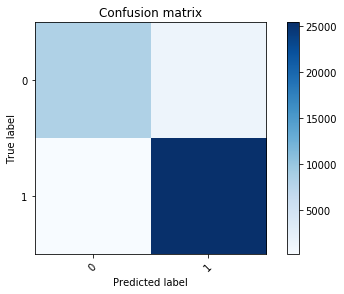

Plotting ROC Curve


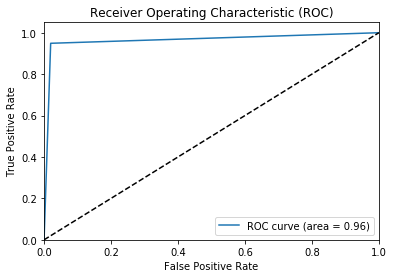

0.9595781574234629
0.9603640429182811
0.9595781574234629
0.9588062754057792
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      9625
           1       0.95      0.99      0.97     25554

    accuracy                           0.96     35179
   macro avg       0.97      0.93      0.95     35179
weighted avg       0.96      0.96      0.96     35179

[[ 8381  1244]
 [  178 25376]]
Ploting confusion matrix


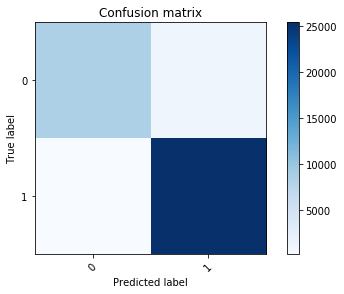

Plotting ROC Curve


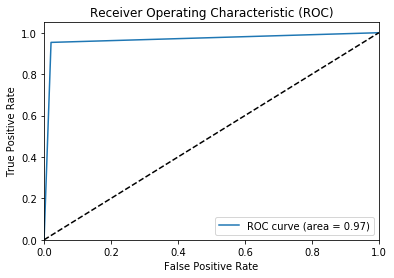

0.9562523096165326
0.9573155441651433
0.9562523096165326
0.9552990176403169
              precision    recall  f1-score   support

           0       0.98      0.86      0.91      9625
           1       0.95      0.99      0.97     25554

    accuracy                           0.96     35179
   macro avg       0.96      0.93      0.94     35179
weighted avg       0.96      0.96      0.96     35179

[[ 8255  1370]
 [  169 25385]]
Ploting confusion matrix


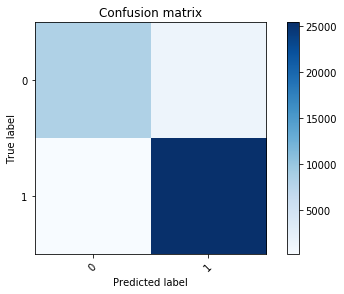

Plotting ROC Curve


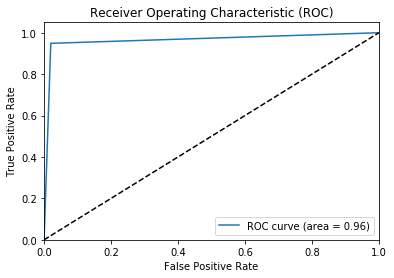

0.959066488530089
0.959842492954097
0.959066488530089
0.9582816056680643
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      9625
           1       0.95      0.99      0.97     25554

    accuracy                           0.96     35179
   macro avg       0.97      0.93      0.95     35179
weighted avg       0.96      0.96      0.96     35179

[[ 8370  1255]
 [  185 25369]]
Ploting confusion matrix


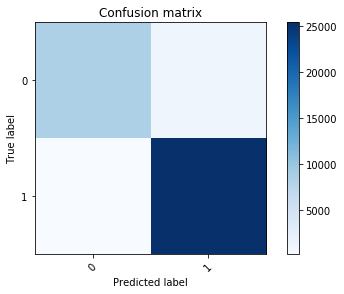

Plotting ROC Curve


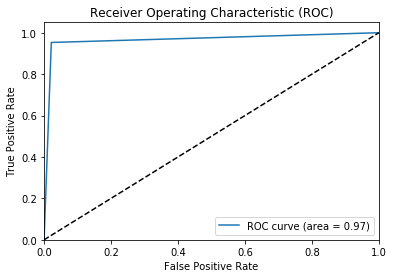

0.9565081440632195
0.9575331556133492
0.9565081440632195
0.955573591471609
              precision    recall  f1-score   support

           0       0.98      0.86      0.92      9625
           1       0.95      0.99      0.97     25554

    accuracy                           0.96     35179
   macro avg       0.96      0.93      0.94     35179
weighted avg       0.96      0.96      0.96     35179

[[ 8267  1358]
 [  172 25382]]
Ploting confusion matrix


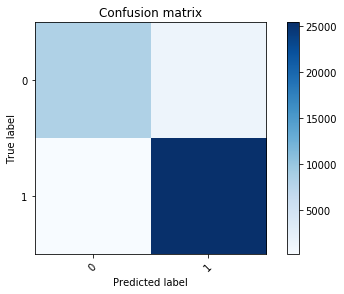

Plotting ROC Curve


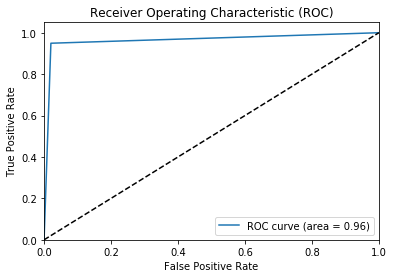

0.9592086187782484
0.9599877075652257
0.9592086187782484
0.958427266164416
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      9625
           1       0.95      0.99      0.97     25554

    accuracy                           0.96     35179
   macro avg       0.97      0.93      0.95     35179
weighted avg       0.96      0.96      0.96     35179

[[ 8373  1252]
 [  183 25371]]
Ploting confusion matrix


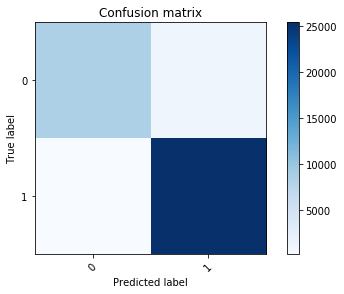

Plotting ROC Curve


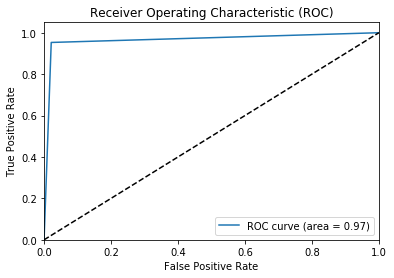

0.9564797180135877
0.9575000195286321
0.9564797180135877
0.9555454315531227
              precision    recall  f1-score   support

           0       0.98      0.86      0.92      9625
           1       0.95      0.99      0.97     25554

    accuracy                           0.96     35179
   macro avg       0.96      0.93      0.94     35179
weighted avg       0.96      0.96      0.96     35179

[[ 8267  1358]
 [  173 25381]]
Ploting confusion matrix


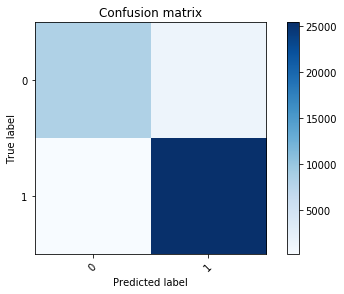

Plotting ROC Curve


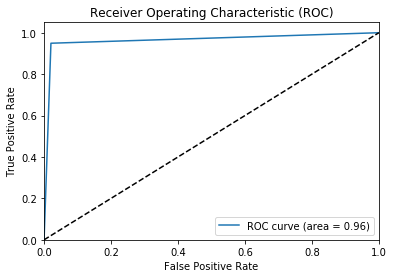

0.9590380624804571
0.959804054641069
0.9590380624804571
0.9582550591015709
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      9625
           1       0.95      0.99      0.97     25554

    accuracy                           0.96     35179
   macro avg       0.97      0.93      0.95     35179
weighted avg       0.96      0.96      0.96     35179

[[ 8371  1254]
 [  187 25367]]
Ploting confusion matrix


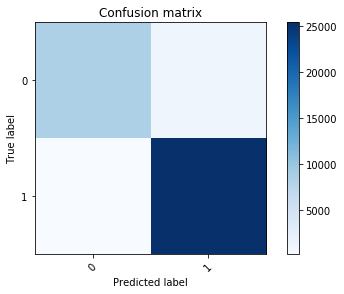

Plotting ROC Curve


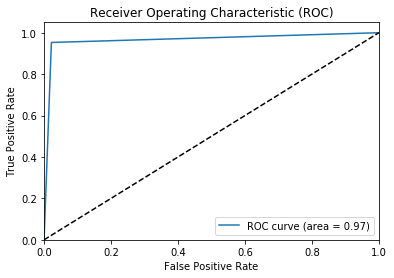

In [31]:
from sklearn.neighbors import KNeighborsClassifier
for i in range(1,25):
    knn = KNeighborsClassifier(n_neighbors=i)
    y = data["label"]
    knn.fit(x, y) 
    #t_predict=data_test['label']
    #data_test.drop('label', axis=1,inplace=True)
    testing = knn.predict(data_test)
    score =metrics.accuracy_score(t_predict,testing)
    print(score)
    score_precision=metrics.precision_score(t_predict,testing,average="weighted")
    score_recall=metrics.recall_score(t_predict,testing,average='weighted')
    score_F1= metrics.f1_score(t_predict,testing,average='weighted')
    print(score_precision)
    print(score_recall)
    print(score_F1)

    print(classification_report(t_predict,testing))

    # Compute confusion matrix
    cm = confusion_matrix(t_predict, testing)
    print(cm)

    #Plotting Confusion Matrix

    print('Ploting confusion matrix')
    plt.figure()
    plot_confusion_matrix(cm, "01")
    plt.show()
                           
    print('Plotting ROC Curve')
    plot_roc(t_predict,testing)
                           

## Logistic Regression

C:\Users\Mohini\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Mohini\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


score_accuracy:  0.9193552971943489
score_precision:  0.926604005903889
score_recall:  0.9193552971943489
score_f1:  0.9146873488862216
              precision    recall  f1-score   support

           0       0.99      0.71      0.83      9625
           1       0.90      1.00      0.95     25554

    accuracy                           0.92     35179
   macro avg       0.95      0.85      0.89     35179
weighted avg       0.93      0.92      0.91     35179

[[ 6794  2831]
 [  123 25431]]
Ploting confusion matrix


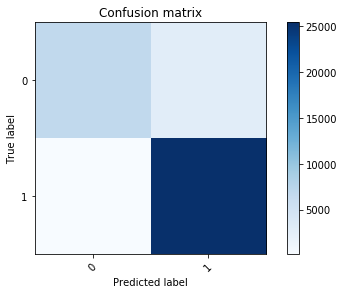

Plotting ROC Curve


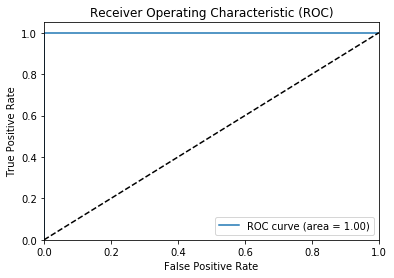

In [33]:
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(x, y)

# predict the response for new observations
logR_pred = logreg.predict(data_test)

score_accuracy_lr= metrics.accuracy_score(t_predict, logR_pred)
score_precision_lr=metrics.precision_score(t_predict, logR_pred, average="weighted")
score_recall_lr=metrics.recall_score(t_predict, logR_pred, average="weighted")
score_f1_lr=metrics.f1_score(t_predict, logR_pred, average="weighted")

print("score_accuracy: " ,score_accuracy_lr)
print("score_precision: " ,score_precision_lr)
print("score_recall: " ,score_recall_lr)
print("score_f1: " ,score_f1_lr)

print(classification_report(t_predict,logR_pred))


# Compute confusion matrix
cm = confusion_matrix(t_predict, pred)
print(cm)

#Plotting Confusion Matrix

print('Ploting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, "01")
plt.show()

print('Plotting ROC Curve')
plot_roc(y_true, t_predict)


## Support Vector Machine (SVM)

C:\Users\Mohini\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


score_accuracy:  0.9258364365104181
score_precision:  0.9322651576995011
score_recall:  0.9258364365104181
score_f1:  0.9219193683247822
              precision    recall  f1-score   support

           0       1.00      0.73      0.84      9625
           1       0.91      1.00      0.95     25554

    accuracy                           0.93     35179
   macro avg       0.95      0.87      0.90     35179
weighted avg       0.93      0.93      0.92     35179

[[ 6794  2831]
 [  123 25431]]
Ploting confusion matrix


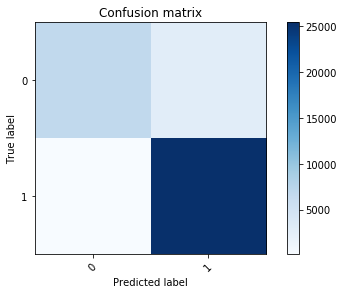

Plotting ROC Curve


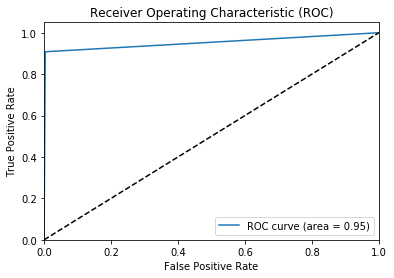

In [34]:
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report

model = svm.SVC() 
model.fit(x, y)
SVM_pred = model.predict(data_test)
score_accuracy_svm= metrics.accuracy_score(t_predict, SVM_pred)
score_precision_svm=metrics.precision_score(t_predict, SVM_pred, average="weighted")
score_recall_svm=metrics.recall_score(t_predict, SVM_pred, average="weighted")
score_f1_svm=metrics.f1_score(t_predict, SVM_pred, average="weighted")

print("score_accuracy: " ,score_accuracy_svm)
print("score_precision: " ,score_precision_svm)
print("score_recall: " ,score_recall_svm)
print("score_f1: " ,score_f1_svm)

#y_true = np.argmax(y_test,axis=1)

print(classification_report(t_predict,SVM_pred))
    
# Compute confusion matrix
cm = confusion_matrix(t_predict, pred)
print(cm)

#Plotting Confusion Matrix

print('Ploting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, "01")
plt.show()

print('Plotting ROC Curve')
plot_roc(y_true, SVM_pred)
